# 📊 Personal Finance Analytics - Complete Example

This notebook demonstrates how to analyze your financial data using the hierarchical category system.

## What you'll learn:
- Connect to your finance database
- Analyze spending patterns by category
- Create interactive visualizations
- Generate financial insights and reports
- Track budget vs actual spending
- Identify trends and anomalies

## 🔧 Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('dark_background')
sns.set_palette("husl")

print("📚 Libraries loaded successfully!")

📚 Libraries loaded successfully!


In [2]:
# Connect to your finance database
conn = sqlite3.connect('data/finance.db')

# Load all your financial data
query = """
SELECT 
    t.id,
    t.date,
    t.description,
    t.amount,
    t.category,
    t.note,
    a.name as account_name,
    a.account_type,
    b.name as bank_name
FROM transactions t
JOIN accounts a ON t.account_id = a.id
JOIN banks b ON a.bank_id = b.id
ORDER BY t.date DESC
"""

df = pd.read_sql_query(query, conn)

# Data preprocessing
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.day_name()
df['is_weekend'] = df['date'].dt.weekday >= 5

# Categorize transactions
df['transaction_type'] = df['amount'].apply(lambda x: 'Income' if x > 0 else 'Expense')
df['abs_amount'] = df['amount'].abs()

print(f"💰 Loaded {len(df):,} transactions")
print(f"📅 Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"🏦 Banks: {', '.join(df['bank_name'].unique())}")
print(f"💳 Accounts: {', '.join(df['account_name'].unique())}")

df.head()

💰 Loaded 0 transactions


ValueError: NaTType does not support strftime

In [ ]:
# Load predefined categories for reference
categories_query = """
SELECT category_path, level_1, level_2, level_3, level_4, display_name
FROM predefined_categories
ORDER BY category_path
"""

categories_df = pd.read_sql_query(categories_query, conn)
print(f"📋 Available categories: {len(categories_df)}")
print("\n🏷️ Main category types:")
for cat in categories_df['level_1'].unique():
    count = len(categories_df[categories_df['level_1'] == cat])
    print(f"   • {cat}: {count} subcategories")

## 📈 Financial Overview Dashboard

In [3]:
# Calculate key financial metrics
total_income = df[df['amount'] > 0]['amount'].sum()
total_expenses = df[df['amount'] < 0]['amount'].sum()
net_worth_change = total_income + total_expenses
avg_monthly_income = df[df['amount'] > 0].groupby('month')['amount'].sum().mean()
avg_monthly_expenses = df[df['amount'] < 0].groupby('month')['amount'].sum().mean()

print("💰 FINANCIAL SUMMARY")
print("=" * 50)
print(f"Total Income:        ${total_income:>12,.2f}")
print(f"Total Expenses:      ${abs(total_expenses):>12,.2f}")
print(f"Net Change:          ${net_worth_change:>12,.2f}")
print(f"Avg Monthly Income:  ${avg_monthly_income:>12,.2f}")
print(f"Avg Monthly Expenses:${abs(avg_monthly_expenses):>12,.2f}")
print(f"Savings Rate:        {(net_worth_change/total_income*100):>11.1f}%")

# Create overview visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Income vs Expenses', 'Monthly Trends', 'Transaction Types', 'Account Balances'),
    specs=[[{"type": "bar"}, {"type": "scatter"}],
           [{"type": "pie"}, {"type": "bar"}]]
)

# Income vs Expenses
fig.add_trace(
    go.Bar(x=['Income', 'Expenses'], y=[total_income, abs(total_expenses)],
           marker_color=['green', 'red'], name='Amount'),
    row=1, col=1
)

# Monthly trends
monthly_data = df.groupby(['month', 'transaction_type'])['amount'].sum().unstack(fill_value=0)
fig.add_trace(
    go.Scatter(x=monthly_data.index.astype(str), y=monthly_data.get('Income', 0),
               mode='lines+markers', name='Income', line=dict(color='green')),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=monthly_data.index.astype(str), y=abs(monthly_data.get('Expense', 0)),
               mode='lines+markers', name='Expenses', line=dict(color='red')),
    row=1, col=2
)

# Transaction types pie chart
type_counts = df['transaction_type'].value_counts()
fig.add_trace(
    go.Pie(labels=type_counts.index, values=type_counts.values, name="Transaction Types"),
    row=2, col=1
)

# Account balances
account_balances = df.groupby('account_name')['amount'].sum()
fig.add_trace(
    go.Bar(x=account_balances.index, y=account_balances.values,
           marker_color='blue', name='Balance'),
    row=2, col=2
)

fig.update_layout(height=800, title_text="📊 Financial Dashboard Overview")
fig.show()

💰 FINANCIAL SUMMARY
Total Income:        $        0.00
Total Expenses:      $        0.00
Net Change:          $        0.00
Avg Monthly Income:  $         nan
Avg Monthly Expenses:$         nan


ZeroDivisionError: division by zero

## 🏷️ Category Analysis with Hierarchical Data

💸 TOP SPENDING CATEGORIES
Category                  Total        Count    Avg       
------------------------------------------------------------
Credit Card Payment       $ 37,595.69    9.0 $4,177.30
Bank Transfer             $ 20,000.00    1.0 $20,000.00
Uncategorized             $    525.78    5.0 $  105.16


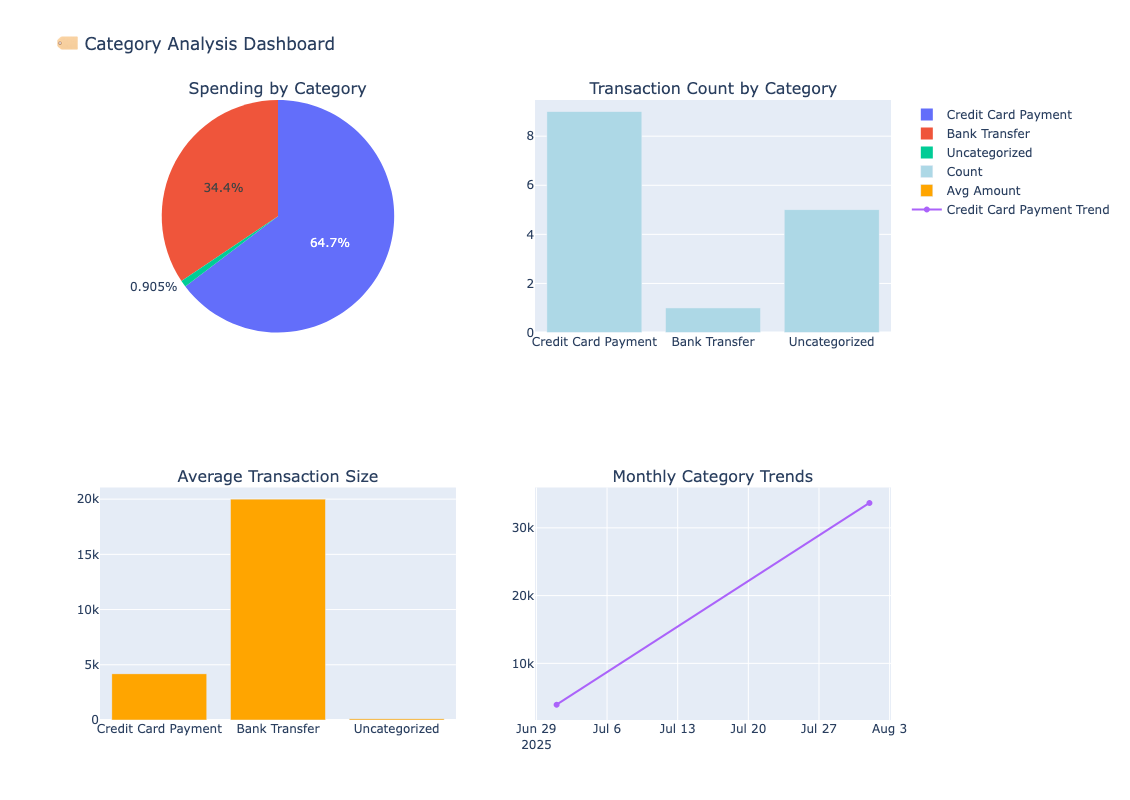

In [5]:
# Analyze spending by category
expense_data = df[df['amount'] < 0].copy()
category_spending = expense_data.groupby('category')['abs_amount'].agg(['sum', 'count', 'mean']).round(2)
category_spending.columns = ['Total_Spent', 'Transaction_Count', 'Avg_Transaction']
category_spending = category_spending.sort_values('Total_Spent', ascending=False)

print("💸 TOP SPENDING CATEGORIES")
print("=" * 60)
print(f"{'Category':<25} {'Total':<12} {'Count':<8} {'Avg':<10}")
print("-" * 60)
for idx, (category, row) in enumerate(category_spending.head(10).iterrows()):
    print(f"{category:<25} ${row['Total_Spent']:>10,.2f} {row['Transaction_Count']:>6} ${row['Avg_Transaction']:>8,.2f}")

# Create interactive category visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Spending by Category', 'Transaction Count by Category', 
                   'Average Transaction Size', 'Monthly Category Trends'),
    specs=[[{"type": "pie"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "scatter"}]]
)

# Top categories pie chart
top_categories = category_spending.head(8)
fig.add_trace(
    go.Pie(labels=top_categories.index, values=top_categories['Total_Spent'],
           name="Spending"),
    row=1, col=1
)

# Transaction count by category
fig.add_trace(
    go.Bar(x=top_categories.index, y=top_categories['Transaction_Count'],
           marker_color='lightblue', name='Count'),
    row=1, col=2
)

# Average transaction size
fig.add_trace(
    go.Bar(x=top_categories.index, y=top_categories['Avg_Transaction'],
           marker_color='orange', name='Avg Amount'),
    row=2, col=1
)

# Monthly trends for top category
top_category = category_spending.index[0]
monthly_category = expense_data[expense_data['category'] == top_category].groupby('month')['abs_amount'].sum()
fig.add_trace(
    go.Scatter(x=monthly_category.index.astype(str), y=monthly_category.values,
               mode='lines+markers', name=f'{top_category} Trend'),
    row=2, col=2
)

fig.update_layout(height=800, title_text="🏷️ Category Analysis Dashboard")
fig.show()

## 📅 Time-Based Analysis

📅 MONTHLY FINANCIAL SUMMARY
Month      Income       Expenses     Net          Savings % 
--------------------------------------------------------------------------------
2025-07    $     3,492 $     4,194 $      -702    -20.1%
2025-08    $    66,421 $    53,927 $    12,494     18.8%


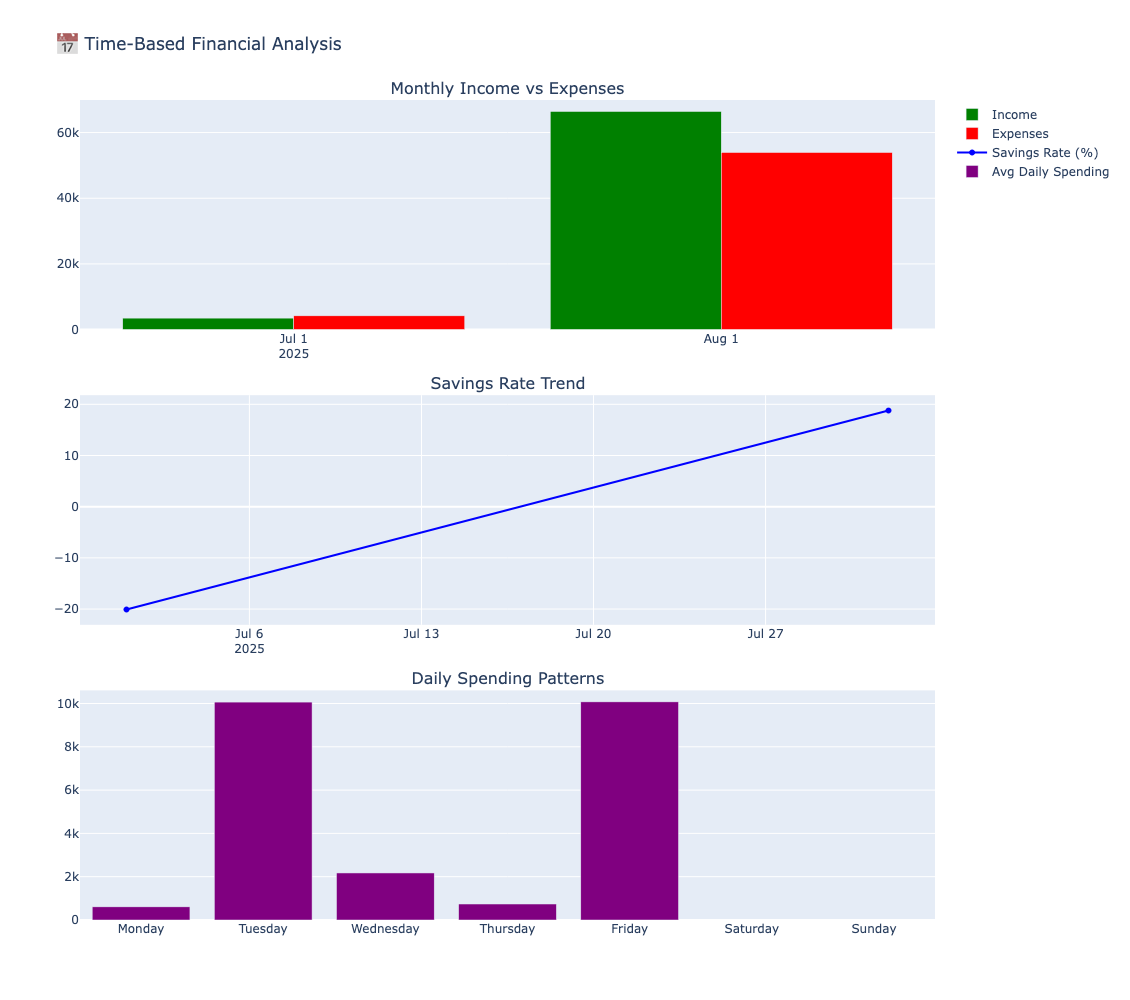

In [6]:
# Analyze spending patterns over time
monthly_summary = df.groupby(['month', 'transaction_type'])['amount'].sum().unstack(fill_value=0)
monthly_summary['Net'] = monthly_summary.get('Income', 0) + monthly_summary.get('Expense', 0)
monthly_summary['Savings_Rate'] = (monthly_summary['Net'] / monthly_summary.get('Income', 1) * 100).round(1)

print("📅 MONTHLY FINANCIAL SUMMARY")
print("=" * 80)
print(f"{'Month':<10} {'Income':<12} {'Expenses':<12} {'Net':<12} {'Savings %':<10}")
print("-" * 80)
for month, row in monthly_summary.tail(6).iterrows():
    income = row.get('Income', 0)
    expenses = row.get('Expense', 0)
    net = row['Net']
    savings_rate = row['Savings_Rate']
    print(f"{str(month):<10} ${income:>10,.0f} ${abs(expenses):>10,.0f} ${net:>10,.0f} {savings_rate:>8.1f}%")

# Create time-based visualizations
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=('Monthly Income vs Expenses', 'Savings Rate Trend', 'Daily Spending Patterns'),
    vertical_spacing=0.08
)

# Monthly income vs expenses
fig.add_trace(
    go.Bar(x=monthly_summary.index.astype(str), y=monthly_summary.get('Income', 0),
           name='Income', marker_color='green'),
    row=1, col=1
)
fig.add_trace(
    go.Bar(x=monthly_summary.index.astype(str), y=abs(monthly_summary.get('Expense', 0)),
           name='Expenses', marker_color='red'),
    row=1, col=1
)

# Savings rate trend
fig.add_trace(
    go.Scatter(x=monthly_summary.index.astype(str), y=monthly_summary['Savings_Rate'],
               mode='lines+markers', name='Savings Rate (%)', line=dict(color='blue')),
    row=2, col=1
)

# Daily spending patterns
daily_spending = expense_data.groupby('day_of_week')['abs_amount'].mean()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_spending = daily_spending.reindex(day_order)

fig.add_trace(
    go.Bar(x=daily_spending.index, y=daily_spending.values,
           name='Avg Daily Spending', marker_color='purple'),
    row=3, col=1
)

fig.update_layout(height=1000, title_text="📅 Time-Based Financial Analysis")
fig.show()

## 🎯 Budget Analysis & Recommendations

🎯 BUDGET ANALYSIS
Average Monthly Income: $34,956.26

Recommended Budget Allocation:
------------------------------------------------------------
Housing         $  10,487 vs $       0 ✅ Under
Food            $   5,243 vs $       0 ✅ Under
Transportation  $   5,243 vs $       0 ✅ Under
Healthcare      $   1,748 vs $       0 ✅ Under
Entertainment   $   3,496 vs $       0 ✅ Under
Savings         $   6,991 vs $       0 ✅ Under
Other           $   1,748 vs $       0 ✅ Under


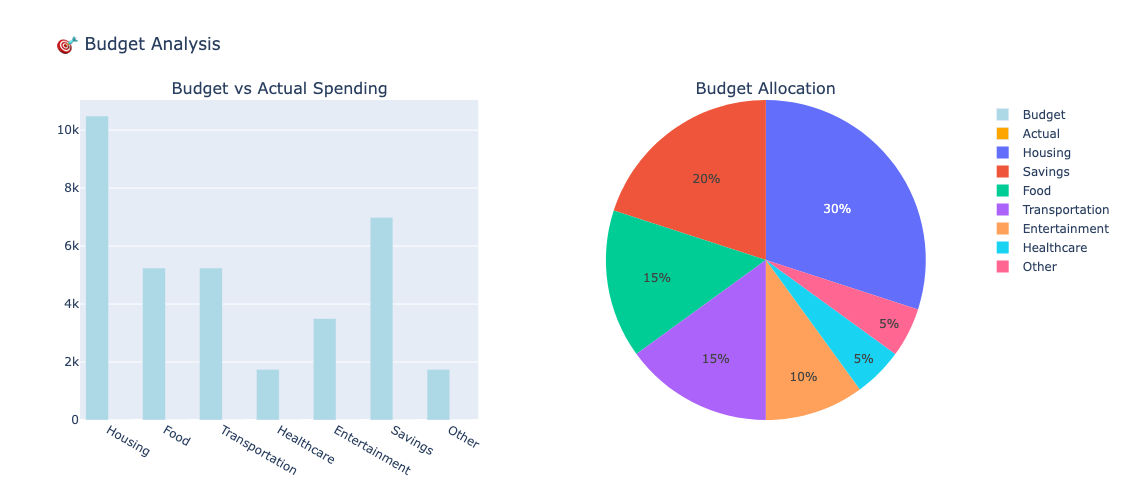

In [7]:
# Create a simple budget based on historical data
# You can modify these percentages based on your financial goals
BUDGET_PERCENTAGES = {
    'Housing': 0.30,      # 30% of income
    'Food': 0.15,         # 15% of income
    'Transportation': 0.15, # 15% of income
    'Healthcare': 0.05,   # 5% of income
    'Entertainment': 0.10, # 10% of income
    'Savings': 0.20,      # 20% of income
    'Other': 0.05         # 5% of income
}

# Calculate budget vs actual for recent months
recent_months = monthly_summary.tail(3)
avg_monthly_income = recent_months.get('Income', 0).mean()

print("🎯 BUDGET ANALYSIS")
print("=" * 60)
print(f"Average Monthly Income: ${avg_monthly_income:,.2f}")
print("\nRecommended Budget Allocation:")
print("-" * 60)

budget_data = []
for category, percentage in BUDGET_PERCENTAGES.items():
    budget_amount = avg_monthly_income * percentage
    
    # Try to match with actual spending categories
    if category == 'Housing':
        actual_categories = ['Rent', 'Mortgage', 'Utilities', 'Electricity', 'Water', 'Gas', 'Internet']
    elif category == 'Food':
        actual_categories = ['Groceries', 'Dining Out', 'Food']
    elif category == 'Transportation':
        actual_categories = ['Fuel', 'Public Transit', 'Car Payment', 'Car Insurance', 'Transportation']
    else:
        actual_categories = [category]
    
    # Calculate actual spending
    actual_spending = 0
    for cat in actual_categories:
        if cat in category_spending.index:
            actual_spending += category_spending.loc[cat, 'Total_Spent'] / len(monthly_summary)
    
    budget_data.append({
        'Category': category,
        'Budget': budget_amount,
        'Actual': actual_spending,
        'Difference': budget_amount - actual_spending,
        'Percentage': percentage * 100
    })
    
    status = "✅ Under" if actual_spending <= budget_amount else "❌ Over"
    print(f"{category:<15} ${budget_amount:>8,.0f} vs ${actual_spending:>8,.0f} {status}")

# Create budget visualization
budget_df = pd.DataFrame(budget_data)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Budget vs Actual Spending', 'Budget Allocation'),
    specs=[[{"type": "bar"}, {"type": "pie"}]]
)

# Budget vs Actual
fig.add_trace(
    go.Bar(x=budget_df['Category'], y=budget_df['Budget'],
           name='Budget', marker_color='lightblue'),
    row=1, col=1
)
fig.add_trace(
    go.Bar(x=budget_df['Category'], y=budget_df['Actual'],
           name='Actual', marker_color='orange'),
    row=1, col=1
)

# Budget allocation pie
fig.add_trace(
    go.Pie(labels=budget_df['Category'], values=budget_df['Budget'],
           name="Budget Allocation"),
    row=1, col=2
)

fig.update_layout(height=500, title_text="🎯 Budget Analysis")
fig.show()

## 🔍 Advanced Analytics & Insights

🔍 UNUSUAL TRANSACTIONS ANALYSIS

💸 Large Expenses (Top 5% - above $23000.00):
   $30,000.00 - Wealthfront EDI PYMNTS 4CC70294874D44 Di (Credit Card Payment)

💰 Large Income (Top 5% - above $30000.00):

📊 SPENDING PATTERNS:
Weekend avg transaction: $nan
Weekday avg transaction: $3874.76
Weekend vs Weekday ratio: nanx


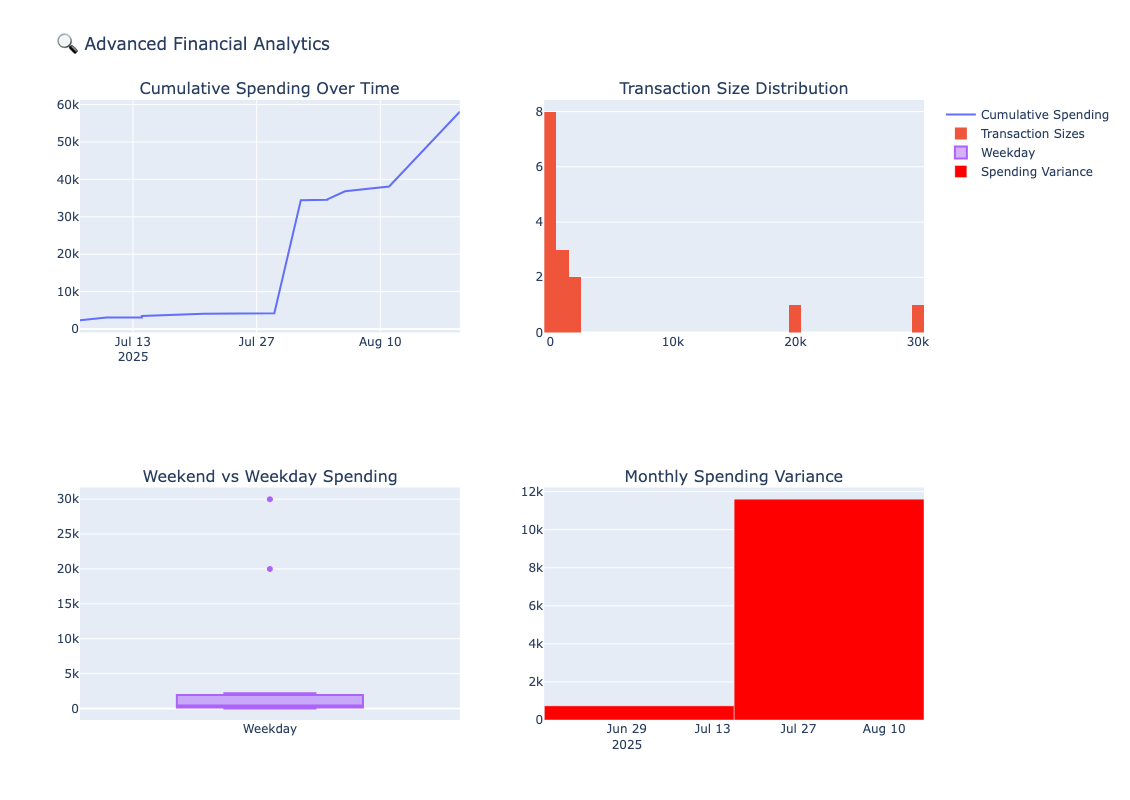

In [8]:
# Find unusual transactions (outliers)
def find_outliers(data, column, threshold=2):
    """Find outliers using z-score method"""
    z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
    return data[z_scores > threshold]

# Analyze large transactions
large_expenses = expense_data[expense_data['abs_amount'] > expense_data['abs_amount'].quantile(0.95)]
large_income = df[(df['amount'] > 0) & (df['amount'] > df[df['amount'] > 0]['amount'].quantile(0.95))]

print("🔍 UNUSUAL TRANSACTIONS ANALYSIS")
print("=" * 70)
print(f"\n💸 Large Expenses (Top 5% - above ${expense_data['abs_amount'].quantile(0.95):.2f}):")
for _, tx in large_expenses.head(5).iterrows():
    print(f"   ${tx['abs_amount']:>8,.2f} - {tx['description'][:40]} ({tx['category']})")

print(f"\n💰 Large Income (Top 5% - above ${df[df['amount'] > 0]['amount'].quantile(0.95):.2f}):")
for _, tx in large_income.head(5).iterrows():
    print(f"   ${tx['amount']:>8,.2f} - {tx['description'][:40]} ({tx['category']})")

# Spending velocity analysis
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
expense_data_sorted = expense_data.sort_values('date')
expense_data_sorted['cumulative_spending'] = expense_data_sorted['abs_amount'].cumsum()

# Find spending patterns
weekend_spending = expense_data[expense_data['is_weekend']]['abs_amount'].mean()
weekday_spending = expense_data[~expense_data['is_weekend']]['abs_amount'].mean()

print(f"\n📊 SPENDING PATTERNS:")
print(f"Weekend avg transaction: ${weekend_spending:.2f}")
print(f"Weekday avg transaction: ${weekday_spending:.2f}")
print(f"Weekend vs Weekday ratio: {weekend_spending/weekday_spending:.2f}x")

# Create advanced analytics visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Cumulative Spending Over Time', 'Transaction Size Distribution',
                   'Weekend vs Weekday Spending', 'Monthly Spending Variance'),
    specs=[[{"type": "scatter"}, {"type": "histogram"}],
           [{"type": "box"}, {"type": "bar"}]]
)

# Cumulative spending
fig.add_trace(
    go.Scatter(x=expense_data_sorted['date'], y=expense_data_sorted['cumulative_spending'],
               mode='lines', name='Cumulative Spending'),
    row=1, col=1
)

# Transaction size distribution
fig.add_trace(
    go.Histogram(x=expense_data['abs_amount'], nbinsx=30, name='Transaction Sizes'),
    row=1, col=2
)

# Weekend vs Weekday box plot
fig.add_trace(
    go.Box(y=expense_data[expense_data['is_weekend']]['abs_amount'], name='Weekend'),
    row=2, col=1
)
fig.add_trace(
    go.Box(y=expense_data[~expense_data['is_weekend']]['abs_amount'], name='Weekday'),
    row=2, col=1
)

# Monthly variance
monthly_variance = expense_data.groupby('month')['abs_amount'].std()
fig.add_trace(
    go.Bar(x=monthly_variance.index.astype(str), y=monthly_variance.values,
           name='Spending Variance', marker_color='red'),
    row=2, col=2
)

fig.update_layout(height=800, title_text="🔍 Advanced Financial Analytics")
fig.show()

## 📋 Financial Health Report

In [9]:
# Generate a comprehensive financial health report
def generate_financial_health_score():
    score = 0
    max_score = 100
    recommendations = []
    
    # Savings rate (30 points)
    savings_rate = (net_worth_change / total_income) * 100
    if savings_rate >= 20:
        score += 30
    elif savings_rate >= 10:
        score += 20
        recommendations.append("💡 Try to increase your savings rate to 20% or higher")
    elif savings_rate >= 0:
        score += 10
        recommendations.append("⚠️ Your savings rate is low. Consider reducing expenses or increasing income")
    else:
        recommendations.append("🚨 You're spending more than you earn. This needs immediate attention")
    
    # Expense diversity (20 points)
    unique_categories = len(expense_data['category'].unique())
    if unique_categories >= 8:
        score += 20
    elif unique_categories >= 5:
        score += 15
    else:
        score += 10
        recommendations.append("📊 Consider categorizing your expenses more specifically for better tracking")
    
    # Regular income (25 points)
    income_consistency = df[df['amount'] > 0].groupby('month')['amount'].sum().std()
    income_mean = df[df['amount'] > 0].groupby('month')['amount'].sum().mean()
    cv = income_consistency / income_mean if income_mean > 0 else 1
    
    if cv < 0.1:
        score += 25
    elif cv < 0.3:
        score += 20
    else:
        score += 10
        recommendations.append("💼 Your income varies significantly. Consider building an emergency fund")
    
    # Spending control (25 points)
    expense_consistency = expense_data.groupby('month')['abs_amount'].sum().std()
    expense_mean = expense_data.groupby('month')['abs_amount'].sum().mean()
    expense_cv = expense_consistency / expense_mean if expense_mean > 0 else 1
    
    if expense_cv < 0.2:
        score += 25
    elif expense_cv < 0.4:
        score += 20
    else:
        score += 10
        recommendations.append("💳 Your spending varies a lot. Try to create and stick to a budget")
    
    return score, recommendations

health_score, recommendations = generate_financial_health_score()

print("🏥 FINANCIAL HEALTH REPORT")
print("=" * 50)
print(f"\n📊 Overall Health Score: {health_score}/100")

if health_score >= 80:
    print("🎉 Excellent! Your finances are in great shape!")
elif health_score >= 60:
    print("👍 Good! You're on the right track with some room for improvement.")
elif health_score >= 40:
    print("⚠️ Fair. There are several areas that need attention.")
else:
    print("🚨 Poor. Your finances need immediate attention.")

print("\n📋 Key Metrics:")
print(f"   • Savings Rate: {(net_worth_change/total_income*100):.1f}%")
print(f"   • Categories Used: {len(expense_data['category'].unique())}")
print(f"   • Avg Monthly Income: ${avg_monthly_income:,.2f}")
print(f"   • Avg Monthly Expenses: ${abs(avg_monthly_expenses):,.2f}")

if recommendations:
    print("\n💡 Recommendations:")
    for i, rec in enumerate(recommendations, 1):
        print(f"   {i}. {rec}")

# Close database connection
conn.close()
print("\n✅ Analysis complete! Database connection closed.")

🏥 FINANCIAL HEALTH REPORT

📊 Overall Health Score: 50/100
⚠️ Fair. There are several areas that need attention.

📋 Key Metrics:
   • Savings Rate: 16.9%
   • Categories Used: 3
   • Avg Monthly Income: $34,956.26
   • Avg Monthly Expenses: $29,060.73

💡 Recommendations:
   1. 💡 Try to increase your savings rate to 20% or higher
   2. 📊 Consider categorizing your expenses more specifically for better tracking
   3. 💼 Your income varies significantly. Consider building an emergency fund
   4. 💳 Your spending varies a lot. Try to create and stick to a budget

✅ Analysis complete! Database connection closed.


## 🚀 Next Steps

Now that you've analyzed your financial data, here are some actions you can take:

### 📊 **Data Quality**
- Review uncategorized transactions and assign proper categories
- Use the auto-categorization feature in the web app
- Import more historical data for better trend analysis

### 💰 **Budget Management**
- Set up monthly budgets based on the analysis above
- Track your progress against these budgets
- Adjust spending in over-budget categories

### 📈 **Financial Goals**
- Set a target savings rate (recommended: 20%+)
- Create an emergency fund (3-6 months of expenses)
- Plan for major purchases or investments

### 🔄 **Regular Monitoring**
- Run this analysis monthly to track progress
- Set up alerts for unusual spending patterns
- Review and adjust your financial strategy quarterly

---

**💡 Pro Tip**: Save this notebook and run it regularly with updated data to track your financial progress over time!